# Amazon SageMaker with XGBoost for Automated Diagnosis with EMR data 
_**what else to put here? **_

---

---

## Contents

1. [Objective](#Objective)
1. [Background](#Background)
1. [Setup Environment](#Setup-Environment)
1. [Load and Explore the Dataset](#Load-and-Explore-Dataset)
1. [Prepare Dataset for Model Training](#Prepare-Dataset-for-Model-Training)
1. [Understand the Algorithm](#Understand-the-Algorithm)
1. [Train the Model](#Train-the-Model)
1. [Deploy and Evaluate the Model](#Deploy-and-Evaluate-the-Model)
1. [Hyperparameter Optimization (HPO)](#Exercise:-Hyperparameter-Optimization-(HPO))
1. [Conclusion](#Conclusion)
1. [Clean up resources](#Clean-up-resources)



---

## Objective 

In this section of the workshop we will walkthrough an example of using Sagemaker to train a machine learning model to classify medical documents using a SageMaker's built-in algorithm- XGboost. 
 
**Bonus activity**: The workshop will also include a bonus activity whereby you will learn how to use SageMaker's automatic Hyperparameter Optimization (HPO) capabilities to improve the model's performance with needing to tune the hyperparameters manually.

**Note**: Teaching in-depth data science approaches for tabular data is outside this scope, however we recommend that you use this notebook as a reference to adapt to your needs for future projects.

---
## Background

AI/ML is undoubtfully speeding up the development of the process of new drug development, be a bridge to personalized medicine using the information of our genomes, and help address the problem of chronic shortage of doctors, especially in countries where health services are underdeveloped. However, significant challenges remain en-route to this utopian destination.

One is that the application of AI to the world's health problems isn't quite good enough yet. The other is the presence of the world's health data in the form of large unstructured medical text, which makes the process costly, time-consuming, and inefficient. WHO estimates that **< 20%** of the [world's medical data](https://www.bbc.com/news/business-48784205) is available in an ingestible format for AI algorithms to learn from. 

Here, we want to do **Next step Prediction** which aims to predict speciality needed for a patient with certain diseases automatically. In real environment, the model can be used for analyzing transcription and then automatic referring to respective specialist. 

The input is the EMR as a raw text file with doctor's notes about the patient, including his/her age, compaints described in free way, patient's history and so on. It is unstructured - different sections of oen patient anamnesis may abscent in another's.

The target labels are represented by the category of undergoing *`Consultation`* only or refer to a specialist for *`Sugery`*.

The value on the solution might be found in helping a doctor to find the optimal solution for diasnostics order. Patient can save time and money, and doctor can serve a patient more efficiently on sparing time for unnecessary diagnostics. Moreover, in difficult cases the algorithm may help a doctor to find a diagnosys faster, which in some cases may be extremely valuable, up to saving lives.

Theoretically some regularities found by the algorithm may help medical researchers to find the idea of treating some deseases, based on their unobvious interconnections with some symptoms.

---
## Setup Environment

Before we can begin, we will need to setup up notebook environment by performing some of the following environment setup:

- **import** some useful libraries (as in any Python notebook)
- **configure** the S3 bucket and folder where data should be stored (to keep our environment tidy)
- **connect** to AWS in general (with [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)) and SageMaker in particular (with the [sagemaker SDK](https://sagemaker.readthedocs.io/en/stable/)), to use the cloud services

While `boto3` is the general AWS SDK for Python, `sagemaker` provides some powerful, higher-level interfaces designed specifically for ML workflows.

In [1]:
import numpy as np  # For matrix operations and numerical processing
import pandas as pd  # For munging tabular data
#pd.set_option('display.max_colwidth', None)

import time
import os
from util.classification_report import generate_classification_report, predict_from_numpy  # helper function for classification reports
from util.preprocess import *

# setting up SageMaker parameters
import sagemaker
import boto3

import matplotlib.pyplot as plt
import seaborn as sns

boto_session = boto3.Session()
region = boto_session.region_name
bucket_name = sagemaker.Session().default_bucket()
bucket_prefix = "emr-mtSample"  # Location in the bucket to store our files
sgmk_session = sagemaker.Session()
sgmk_client = boto_session.client("sagemaker")
sgmk_role = sagemaker.get_execution_role()

---
## Load and Explore Dataset

To begin, we will load the dataset from our previous notebook [2.Batch_Data_Processing](./2.Batch_Data_Processing.ipynb). This dataset contains labelled data based on the medical speciality - Surgery or not Surgery and the medical conditions that were extracted from the electronic medical reports.
You can find the processed dataset in the following location '/data/processed_combined_wide.csv'.

**Note**: The original raw dataset that this workshop is based on is available at [kaggle](https://www.kaggle.com/tboyle10/medicaltranscriptions).

*Demographics:*
* `ID`: id of the patients (int)
* `Label`: the patient needs surgery? (bool)
* `nontender`: medical condition extracted from doctos'notes. the number indicate confidence of the symptom (float)
* the rest columns are other medical condistions ...

In [2]:
df_wide=pd.read_csv("./data/processed_combined_wide.csv")
df_wide.head()

,ID,Label,nontender,foreign body,edema,alert,murmur,chest pain,vomiting,hiatal hernia,...,fracture,lesion,ulceration,nausea,cough,tumor,soft,shortness of breath,injury,diabetes
0,337,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.875847,0.0,0.0,0.413122,0.0
1,1054,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,225,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,1086,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.776443,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,304,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.994752,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


#### Explore correlation between the input variables and output one

Let us start by looking at the correlation between the input features and our label (Surgry/Not Surgery).

+ Observation 1: *`wound`* and *`hypertension`* is postively and negatively correlated with Surgery. 
+ Observation 2: *`nausea` and *`vomitting`* is positively correlated
+ Did you observe any more from the plot?

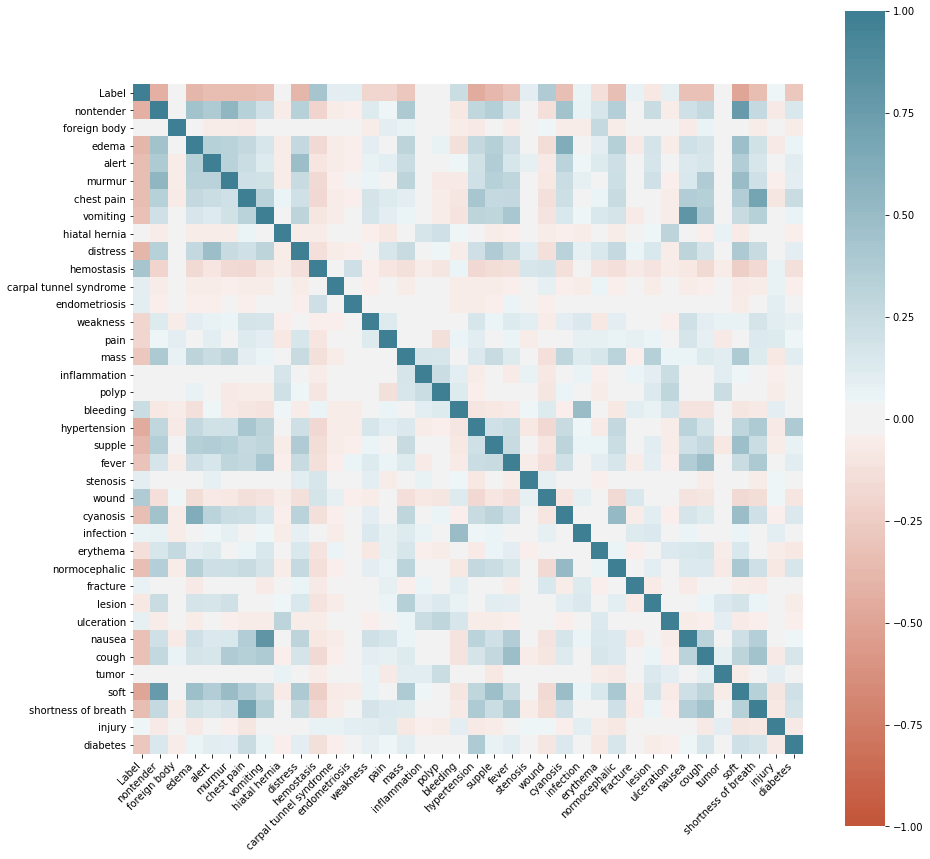

In [3]:
corrPlot(df_wide)

## Prepare Dataset for Model Training

Next, we will start training the model. But before we can proceeed, we need to:

1. Suffle and split the data into **Training (80%)**, **Validation (10%)**, and **Test (10%)** sets
2. Convert the data to the format the algorithm expects (e.g. CSV)
3. Upload the data to S3
4. Create `s3_input` objects defining the data sources for the SageMaker SDK

The training and validation datasets will be used during the training (and tuning) phase, while the 'holdout' test set will be used afterwards to evaluate the model.

Please note that to train the SageMaker XGBoost algorithm, it expects data in the **libSVM** or **CSV** formats with the following format:

- The target variable in the first column, and
- No header row

You can find more information about this [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost).

In [4]:
# remove the id column 
df_combined_model=df_wide.iloc[:,1:] 
# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(df_combined_model.sample(frac=1, random_state=123), 
                                                  [int(0.8 * len(df_combined_model)), int(0.9*len(df_combined_model))],) 

# Create CSV files for Train / Validation / Test
train_data.to_csv("data/train.csv", index=False, header=False)
validation_data.to_csv("data/validation.csv", index=False, header=False)
test_data.to_csv("data/test.csv", index=False, header=True)

### Upload dataset to S3

In [5]:
# Upload CSV files to S3 for SageMaker training
train_uri = sgmk_session.upload_data(
    path="data/train.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix
)
val_uri = sgmk_session.upload_data(
    path="data/validation.csv",
    bucket=bucket_name,
    key_prefix=bucket_prefix
)


# Create s3_inputs
s3_input_train = sagemaker.s3_input(s3_data=train_uri, content_type="csv")
s3_input_validation = sagemaker.s3_input(s3_data=val_uri, content_type="csv")

print(f"{s3_input_train.config}\n\n{s3_input_validation.config}")

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-627317836889/emr-mtSample/train.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-627317836889/emr-mtSample/validation.csv', 'S3DataDistributionType': 'FullyReplicated'}}, 'ContentType': 'csv'}


## Understand the Algorithm
more about xgboost

In [6]:
# specify container
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(region, "xgboost", repo_version="latest")

print(training_image)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest


In [7]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_name=training_image,           # XGBoost algorithm container
    train_instance_type="ml.m5.xlarge",  # type of training instance
    train_instance_count=1,              # number of instances to be used
    role=sgmk_role,                      # IAM role to be used
    train_use_spot_instances=True,       # Use spot instances to reduce cost
    train_max_run=20*60,                 # Maximum allowed active runtime
    train_max_wait=30*60,                # Maximum clock time (including spot delays)
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150,     # int: [1,300]
    max_depth=5,     # int: [1,10]
    alpha=2.5,         # float: [0,5]
    eta=0.5,           # float: [0,1]
    objective="binary:logistic",
)

# start a training (fitting) job
estimator.fit({ "train": s3_input_train, "validation": s3_input_validation })

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-14 03:39:34 Starting - Starting the training job...
2020-09-14 03:39:37 Starting - Launching requested ML instances......
2020-09-14 03:40:52 Starting - Preparing the instances for training...
2020-09-14 03:41:28 Downloading - Downloading input data...
2020-09-14 03:42:02 Training - Training image download completed. Training in progress..Arguments: train
[2020-09-14:03:42:03:INFO] Running standalone xgboost training.
[2020-09-14:03:42:03:INFO] File size need to be processed in the node: 0.07mb. Available memory size in the node: 8165.3mb
[2020-09-14:03:42:03:INFO] Determined delimiter of CSV input is ','
[03:42:03] S3DistributionType set as FullyReplicated
[03:42:03] 313x37 matrix with 11581 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-14:03:42:03:INFO] Determined delimiter of CSV input is ','
[03:42:03] S3DistributionType set as FullyReplicated
[03:42:03] 39x37 matrix with 1443 entries loaded from /opt/ml/input/data/validation?fo

## Deploy and Evaluate the Model
Now that we've trained the xgboost algorithm on our data, deploying the model (hosting it behind a real-time endpoint) is just one function call!

This deployment might take up to 10 minutes, and by default the code will wait for the deployment to complete.
If you like, you can instead:
+ Un-comment the wait=False parameter
+ Use the Endpoints page of the SageMaker Console to check the status of the deployment
+ Skip over the Evaluation section below (which won't run until the deployment is complete), and start the Hyperparameter Optimization job - which will take a while to run too, so can be started in parallel

In [8]:
# Real-time endpoint:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    # wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [9]:
# (This cell will error, until the endpoint deployment above is finished!)

def predict_from_numpy(predictor, data):
    # Configure predictor for CSV input:
    predictor.content_type = "text/csv"
    predictor.serializer = sagemaker.predictor.csv_serializer
    # Fetch result and load back to numpy:
    return np.fromstring(predictor.predict(data).decode("utf-8"), sep=",")

# Get predictions for the test set:
predictions = predict_from_numpy(predictor, test_data.drop(["Label"], axis=1).values)

print(predictions)

[0.04076985 0.95482254 0.14554942 0.977777   0.77384996 0.88020438
 0.25182733 0.95796651 0.02788325 0.977777   0.61633736 0.85817772
 0.08917862 0.01302392 0.977777   0.02785874 0.41558602 0.02788325
 0.61633736 0.01655744 0.61633736 0.48086715 0.87279713 0.61633736
 0.9508239  0.61633736 0.22000095 0.61633736 0.61633736 0.01166393
 0.977777   0.87563074 0.94084626 0.53952056 0.90929419 0.49379238
 0.61633736 0.02422975 0.61633736 0.02602399]


In [16]:
from  imp import reload
from util import classification_report
reload(classification_report)
from util.classification_report import predict_from_numpy 
#from util.classification_report import predict_from_numpy

predictions = predict_from_numpy(predictor, test_data.drop(["Label"], axis=1).values)


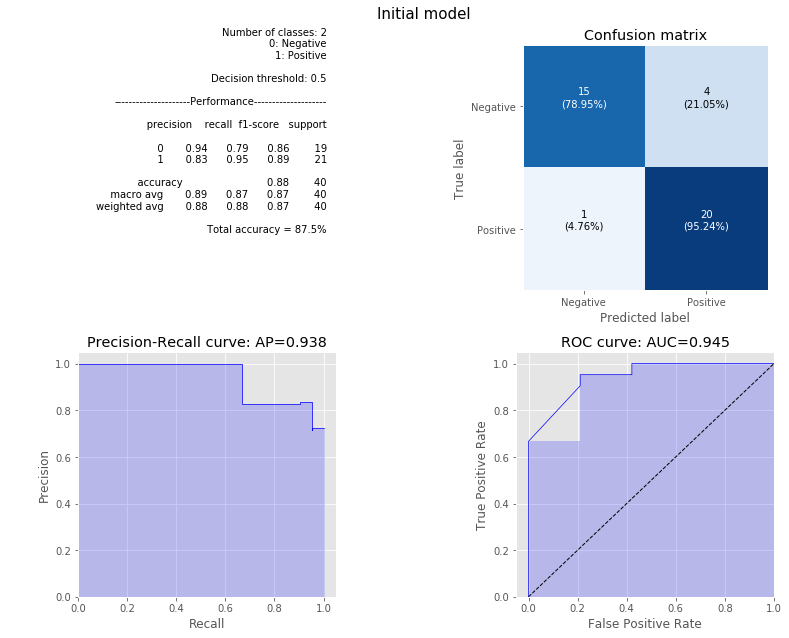

In [17]:
from util.classification_report import generate_classification_report  # helper function for classification reports

generate_classification_report(
    y_real=test_data['Label'].values, 
    y_predict_proba=predictions, 
    decision_threshold=0.5,
    class_names_list=["Negative", "Positive"],
    title="Initial model",
)

## Exercise: Hyperparameter Optimization (HPO)

Now that we've trained our model using some pre-defined hyperparamters, let us try and see if we can improve the model performance by using SageMaker HyperParameter Optimization (HPO) by automating the search for an optimal hyperparameter. Specifically, we **specify a range**, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune.

SageMaker hyperparameter tuning will automatically launch **multiple training jobs** with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will specify the maximum number of HPO tries (`max_jobs`) and how many of these can happen in parallel (`max_parallel_jobs`).

Tip: `max_parallel_jobs` creates a **trade-off between performance and speed** (better hyperparameter values vs how long it takes to find these values). If `max_parallel_jobs` is large, then HPO is faster, but the discovered values may not be optimal. Smaller `max_parallel_jobs` will increase the chance of finding optimal values, but HPO will take more time to finish.

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. Since we are using built-in XGBoost algorithm here, it emits two predefined metrics: **validation:auc** and **train:auc**, and we elected to monitor *validation:auc* as you can see below. In this case (because it's pre-built for us), we only need to specify the metric name. For more information on parameter tuning of XGboost, please refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) 

For more information on Sagemaker HPO please refer to the documentation [here](https://sagemaker.readthedocs.io/en/stable/tuner.html).

**Note:** with the default settings below, the hyperparameter tuning job can take up to ~20 minutes to complete.

In [18]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# set up hyperparameter ranges
ranges = {
    "num_round": IntegerParameter(100, 300),
    "max_depth": IntegerParameter(1, 10),
    "alpha": ContinuousParameter(0, 5),
    "eta": ContinuousParameter(0, 1),
}

# set up the objective metric
objective = "validation:auc"
#objective = "validation:accuracy"
# instantiate a HPO object
tuner = HyperparameterTuner(
    estimator=estimator,              # the SageMaker estimator object
    hyperparameter_ranges=ranges,     # the range of hyperparameters
    max_jobs=10,                      # total number of HPO jobs
    max_parallel_jobs=2,              # how many HPO jobs can run in parallel
    strategy="Bayesian",              # the internal optimization strategy of HPO
    objective_metric_name=objective,  # the objective metric to be used for HPO
    objective_type="Maximize",        # maximize or minimize the objective metric
)  




In [19]:
# start HPO
tuner.fit({ "train": s3_input_train, "validation": s3_input_validation })

In [20]:
%%time
# wait, until HPO is finished
hpo_state = "InProgress"

while hpo_state == "InProgress":
    hpo_state = sgmk_client.describe_hyper_parameter_tuning_job(
                HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)["HyperParameterTuningJobStatus"]
    print("-", end="")
    time.sleep(60)  # poll once every 1 min

print("\nHPO state:", hpo_state)



------------------
HPO state: Completed
CPU times: user 281 ms, sys: 10.2 ms, total: 291 ms
Wall time: 18min 3s


In [21]:
# deploy the best model from HPO
hpo_predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


2020-09-14 04:26:42 Starting - Preparing the instances for training
2020-09-14 04:26:42 Downloading - Downloading input data
2020-09-14 04:26:42 Training - Training image download completed. Training in progress.
2020-09-14 04:26:42 Uploading - Uploading generated training model
2020-09-14 04:26:42 Completed - Training job completedArguments: train
[2020-09-14:04:26:30:INFO] Running standalone xgboost training.
[2020-09-14:04:26:30:INFO] Setting up HPO optimized metric to be : auc
[2020-09-14:04:26:30:INFO] File size need to be processed in the node: 0.07mb. Available memory size in the node: 7996.19mb
[2020-09-14:04:26:30:INFO] Determined delimiter of CSV input is ','
[04:26:30] S3DistributionType set as FullyReplicated
[04:26:30] 313x37 matrix with 11581 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-14:04:26:30:INFO] Determined delimiter of CSV input is ','
[04:26:30] S3DistributionType set as FullyReplicated
[04:26:30] 39x37 matrix with 

In [23]:
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor

#hpo_predictor=RealTimePredictor(endpoint = 'xgboost-200907-0605-005-ee78b161')

test_data=pd.read_csv("data/test.csv")
test_data.head()

,Label,nontender,foreign body,edema,alert,murmur,chest pain,vomiting,hiatal hernia,distress,...,fracture,lesion,ulceration,nausea,cough,tumor,soft,shortness of breath,injury,diabetes
0,0,0.000000,0.0,0.000000,0.000000,0.996897,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.98563,0.0,0.0,0.000000
1,1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.984129,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000
2,0,0.950015,0.0,0.999364,0.889532,0.000000,0.981566,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.998785,0.0,0.994374,0.00000,0.0,0.0,0.990578
3,1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.761079,0.00000,0.0,0.0,0.000000
4,1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000


[0.21176811 0.86889189 0.15042636 0.95067984 0.59240657 0.69176888
 0.0999362  0.86889189 0.12064163 0.95067984 0.58827025 0.69176888
 0.20349678 0.04672866 0.95067984 0.10230418 0.48059496 0.16399398
 0.58827025 0.09666157 0.58827025 0.48059496 0.49981433 0.58827025
 0.80839497 0.58827025 0.48059496 0.58827025 0.58827025 0.01549826
 0.95067984 0.73206729 0.80839497 0.68492246 0.81103015 0.48059496
 0.58827025 0.06512666 0.58827025 0.05388817]


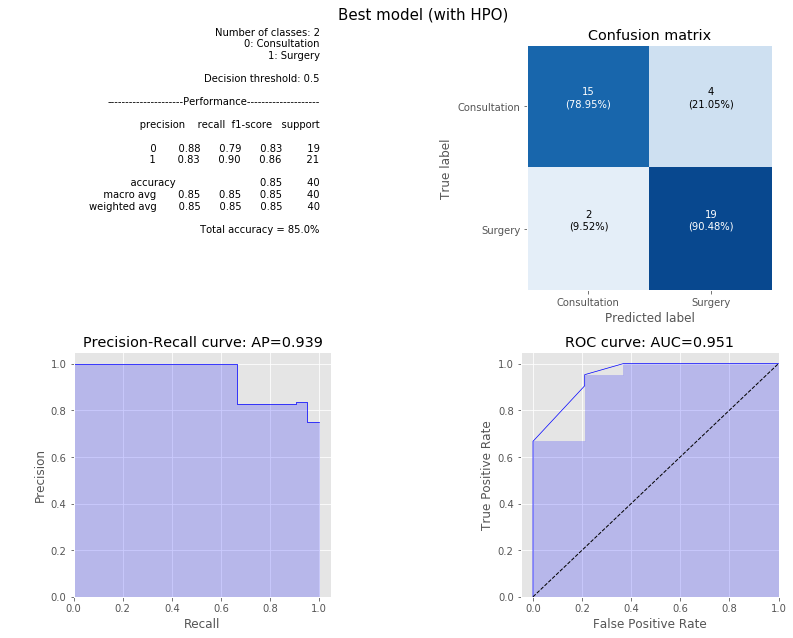

In [24]:
# getting the predicted probabilities of the best model
hpo_predictions = predict_from_numpy(hpo_predictor, test_data.drop(["Label"], axis=1).values)
print(hpo_predictions)

# generate report for the best model
generate_classification_report(
    y_real=test_data["Label"].values, 
    y_predict_proba=hpo_predictions, 
    decision_threshold=0.5,
    class_names_list=["Consultation","Surgery"],
    title="Best model (with HPO)",
)

## Conclusion

In our run, the optimized HPO model exhibited an AUC of ~0.774: fairly higher than our first-guess parameter combination!

Depending on the number of tries, HPO can find a better performing model faster, compared to simply trying different hyperparameters by trial and error or grid search. You can learn more in-depth details about SageMaker HPO [here](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

SageMaker built-in algorithms are great for getting a first model fast, and combining them with SageMaker HPO can really boost their accuracy.

As we mentioned here, the best way to success with a built-in algorithm is to **read the [algorithm's doc pages](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html) carefully** - to understand what data format and parameters it needs!


## Clean up resources
delete the endpoint if needed

In [ ]:
# predictor.delete_endpoint(delete_endpoint_config=True)
# hpo_predictor.delete_endpoint(delete_endpoint_config=True)